In [44]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

def report_noisy_max(data, options, score_function, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [score_function(data, r) for r in options]

    # Add noise to each score
    noisy_scores = [laplace_mech(score, sensitivity, epsilon) for score in scores]

    # Find the index of the maximum score
    max_idx = np.argmax(noisy_scores)

    # Return the element corresponding to that index
    return options[max_idx]

# Introduction

The Multiplicative Weights with Exponential Mechanism (MWEM) mechanism is a differentially private, workload-aware algorithm for modeling the distribution of a private dataset. It can be used to answer query workloads, to generate synthetic data, or to build models that could be used for other purposes. The algorithm was original presented in the paper [A Simple and Practical Algorithm for Differentially Private Data Release](https://proceedings.neurips.cc/paper_files/paper/2012/file/208e43f0e45c4c78cafadb83d2888cb6-Paper.pdf) by Moritz Hardt, Katrina Ligett, and Frank McSherry. MWEM has remained an influential approach since its introduction, since it's simple and easy to implement but also works well in many cases.

The complete algorithm (screenshotted from the paper) appears below, in Figure 1. The inputs to the algorithm are:

- The (private) dataset $B$
- A set $Q$ of linear queries, often called the query workload
- The number of iterations $T$ to run the algorithm
- The privacy budget $\epsilon$
- The number of data records $n$

The algorithm outputs a *probability distribution* over all possible data points in $D$. Sampling from this distribution yields synthetic data; it can also be used directly to answer arbitrary linear queries. The rest of this post describes and implements the pieces of the algorithm.

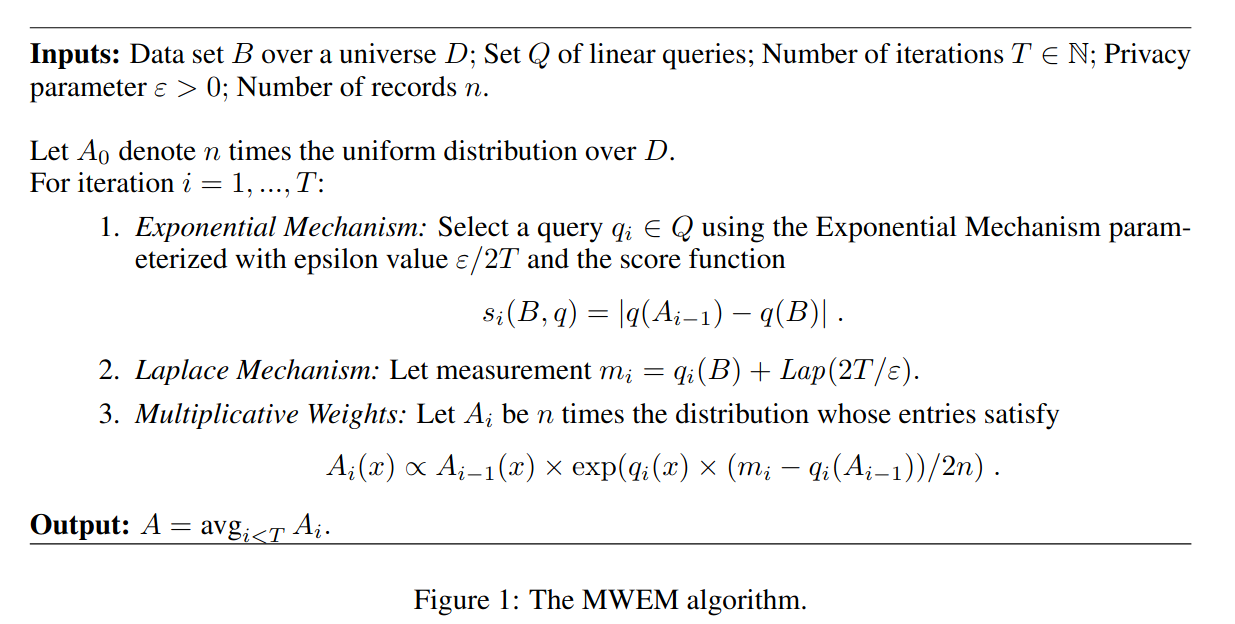

# The Private Data

The algorithm's first argument, $B$, is a private dataset. For our implementation, we'll use the `Age` column of the Adult dataset.

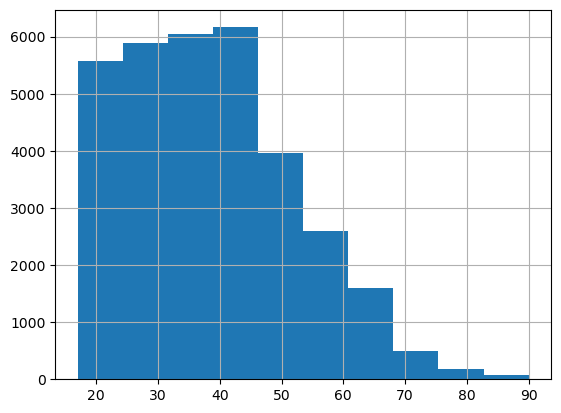

In [34]:
B = adult['Age']
B.hist();

# The Query Workload

The algorithm's second argument, $Q$, is a set of linear queries. Here, a *linear* query refers to a query that can be written as a weighted sum of elements; counts and sums are typical examples of linear queries. $Q$ in the algorithm is a set of these queries, and is often called a *query workload* in other papers. 

In a workload-aware algorithm like MWEM, the goal is to build a model that does a good job answering the queries in the workload, under the assumption that the analyst has used domain-specific knowledge to carefully design the workload so it includes all of the most important queries. In practice, generating a good workload is actually really difficult, because most analysts don't know exactly what the data will be used for when building the differentially private data release. Most papers use simple stand-ins for the workload, like 2- or 3-way marginal queries, prefix queries, or range queries.

Our implementation supports arbitrary linear queries, but we'll use random [range queries](https://programming-dp.com/ch10.html#application-range-queries) as our workload. Specifically, our range queries will count the number of individuals in the dataset whose ages lie within an interval. The `range_query` function implements a range query on a pandas dataframe.

In [56]:
def range_query(data, q):
    lower, upper = q
    return len(data[(data >= lower) & (data < upper)])

We generate 100 random range queries for the `Age` column of the Adult dataset. We represent the queries using the upper and lower bound for each range. We can run these queries by calling the `range_query` function: the code below generates the queries, runs `range_query` to get the answers, and prints the first 5 elements of each.

In [61]:
NUM_QUERIES = 100
random_lower_bounds = [random.randint(1, 70) for _ in range(NUM_QUERIES)]
Q = [(lb, random.randint(lb, 100)) for lb in random_lower_bounds]
real_answers = [range_query(B, q) for q in random_workload]
print('First 5 queries: ', Q[:5])
print('First 5 answers: ', real_answers[:5])

First 5 queries:  [(12, 52), (16, 83), (59, 60), (44, 54), (9, 49)]
First 5 answers:  [1595, 31932, 2545, 11855, 15005]


# Step 0: Initialize the Model

The first step of the algorithm says: "Let $A_0$ denote $n$ times the uniform distribution over $D$." What does that mean?

In our case, where the dataset is the `Age` column of the Adult dataset, $D$ is the universe of all possible ages. If we assume nobody is older than 100 years old, then we could use the numbers from 0 to 100 for our universe.

In [62]:
D = list(range(0, 100))

Since $D$ is finite, we can represent a probability distribution over $D$ as a mapping from each element of $D$ to its probability (i.e. a [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function) (PMF)). The PMF for the uniform distribution in this case assigns equal probability to each element of $D$. Since we have 100 ages, the probability for each one is 1%. Finally, $n$ times this distribution scales each entry by $n$.

In [101]:
n = len(adult)
uniform_D = {x: 1/len(D) for x in D} # give each record equal weight
A_0 = {x: n*uniform_D[x] for x in D} # scale each probability by n to get synthetic data

print('Probability of age 20:', uniform_D[20])
print('Number of synthetic records of age 20:', A_0[20])

Probability of age 20: 0.01
Number of synthetic records of age 20: 325.61


In the code above, `uniform_D` represents a probability distribution, and `A_0` can be considered a *synthetic dataset*. If the probability that an individual's age is 20 is 1%, and the Adult dataset has 32,561 people, then the expected number of 20-year-olds in a synthetic dataset sampled from the distribution would be 325.61. We can run a range query on the synthetic data by adding up the values of `A_0` for ages in the range:

In [102]:
def range_query_synthetic(A, q):
    lower, upper = q
    return sum([A[age] for age in range(lower, upper)])

range_query_synthetic(A_0, Q[0])

13024.400000000005

# Step 1: Select a Query

The first step of the algorithm selects a query from the workload. The goal is to select the *worst* query: the one for which the current synthetic data gives an answer with the worst error. To do this, we use the [exponential mechanism](https://programming-dp.com/ch9.html), which allows selecting from a set of options in a differentially private way. Our implementation uses report noisy max, an easy-to-implement version of the exponential mechanism.

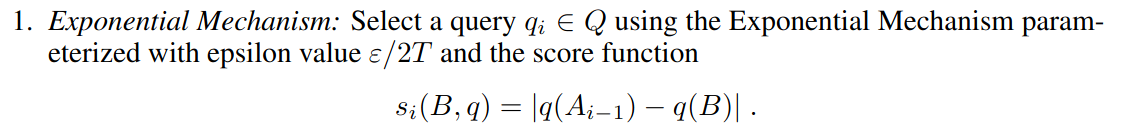

The key challenge is defining the score function for the use of the exponential mechanism, and bounding its sensitivity. We define the score of a query $q \in Q$ as:

1. Calculate the query's result on the synthetic data ($q(A_{i-1})$ from Figure 1)
2. Calculate the query's result on the real data ($q(B)$ from Figure 1)
3. Return the absolute difference between them - the error of the synthetic data for this query

In [103]:
def mk_score_function(A_last):
    def score_function(data, q):
        syn_answer = range_query_synthetic(A_last, q)  # run the query on the synthetic data
        real_answer = range_query(data, q)             # run the query on the real data
        return abs(syn_answer - real_answer)          # score is the absolute difference
    return score_function

We use a nested function here because we will need to adjust the value of `A_last` as the algorithm runs. We can generate a score function for `A_0` and run it to see the error of the synthetic data on the first five queries of the workload:

In [104]:
score_fun = mk_score_function(A_0)
for q in Q[:5]:
    print(q, score_fun(B, q))

(12, 52) 13671.599999999995
(16, 83) 10678.12999999998
(59, 60) 29.389999999999986
(44, 54) 2905.899999999999
(9, 49) 11897.599999999995


Under this scoring function, queries with large error will receive high scores. Picking the query with the maximum score corresponds to picking the query with the maximum error. The sensitivity of this function is 1, since `real_answer` is a range query with a sensitivity of 1. Thus we can use `report_noisy_max` to pick the highest-error query with differential privacy:

In [105]:
q_i = report_noisy_max(data = B, 
                       options = Q, 
                       score_function = mk_score_query(A_0), 
                       sensitivity = 1.0, 
                       epsilon = 1.0)
q_i

(20, 50)

# Step 2: Perform a Measurement

The second step of the algorithm performs a *measurement*: it calculates the result of the worst-error query on the real data, and adds Laplace noise to satisfy differential privacy. Again, the sensitivity is 1, because $q_i$ is a range query.

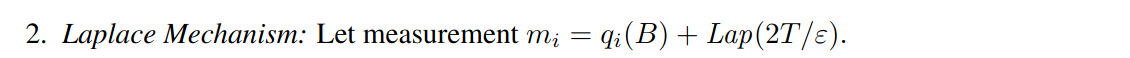

In [106]:
m_i = laplace_mech(range_query(B, q_i),
                   sensitivity = 1,
                   epsilon = 1.0)
m_i

23841.343998920343

# Step 3: Multiplicative Weights

The final step of the algorithm calculates the new synthetic data $A_i$ based on the prior synthetic data $A_{i-1}$ using the [multiplicative weights update rule](https://en.wikipedia.org/wiki/Multiplicative_weight_update_method).

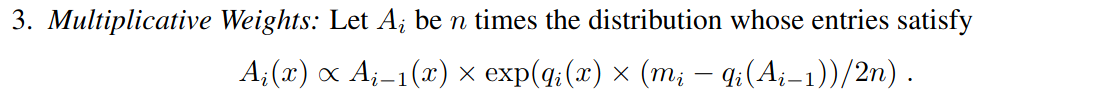

The rule involves calculating a probability distribution for $A_i$ and then scaling it by $n$, as we did for `A_0`. The key idea behind the rule is to scale the probability of each element $x$ based on the (signed) difference between the measurement $m_i$ and the query's result on the old synthetic data. In Python, we can write:

In [119]:
def in_range(q, x): # indicator function: 1 if x is in range, 0 otherwise
    lower, upper = q
    return int(x >= lower and x < upper)

def mw_update(A_last, q_i, m_i):
    A_i_p = {x: A_last[x] * np.exp(in_range(q_i, x) * (m_i - range_query_synthetic(A_last, q_i))/(2*n))
             for x in D}                      # run the MW update rule
    total = sum(A_i_p.values())               # calculate total for normalization
    A_i = {x: n * A_i_p[x]/total for x in D}  # normalize, then scale by n
    return A_i
    
A_1 = mw_update(A_0, q_i, m_i)
print('Number of 10-year-olds:', A_1[10])
print('Number of 20-year-olds:', A_1[20])

Number of 10-year-olds: 303.6361616820854
Number of 20-year-olds: 376.8822894084668


The `mw_update` function implements the MW update rule, returning $A_i$. It's implemented in terms of `in_range`, an indicator function that implements $q_i(x)$ from Figure 1. The `A_i_p` dictionary defines the un-normalized PMF defined by the rule. After building the distribution, we normalize it (as directed by the $\propto$ symbol in Figure 1) and scale it by $n$.

After running the rule, notice that elements outside the range (e.g. 10-year-olds) have been scaled down, while elements inside the range (e.g. 20-year-olds) have been scaled up. By repeating this rule, the MWEM algorithm iteratively refines $A_i$ to more closely match the true data for the queries in $Q$.

# Completing the Algorithm

We can now define the complete algorithm in terms of the steps we've written so far. The only change from the code above is the splitting of the privacy budget: we use $\epsilon/(2*T)$ for each step, so that the total privacy budget equals $\epsilon$ by sequential composition.

In [137]:
def mwem(B, Q, T, epsilon, n):
    # Step 0: initialize A_i
    A_0 = {x: n*uniform_D[x] for x in D} # scale each probability by n to get synthetic data
    A_i = A_0
    
    for i in range(T):
        if i % 10 == 0:
            plt.plot(list(A_i.values()), label=f'Iteration {i}') # plot synthetic data
            plt.legend()

        # Step 1: Select a query
        q_i = report_noisy_max(data = B, 
                               options = Q, 
                               score_function = mk_score_query(A_i), 
                               sensitivity = 1.0, 
                               epsilon = epsilon/(2*T))
        
        # Step 2: Perform a measurement
        m_i = laplace_mech(range_query(B, q_i),
                           sensitivity = 1,
                           epsilon = epsilon/(2*T))
        
        # Step 3: Run MW update
        A_i = mw_update(A_i, q_i, m_i)

    return A_i

In the code above, we also plot the synthetic data values in each iteration (with `plt.plot`), to visualize how the synthetic data changes over time.

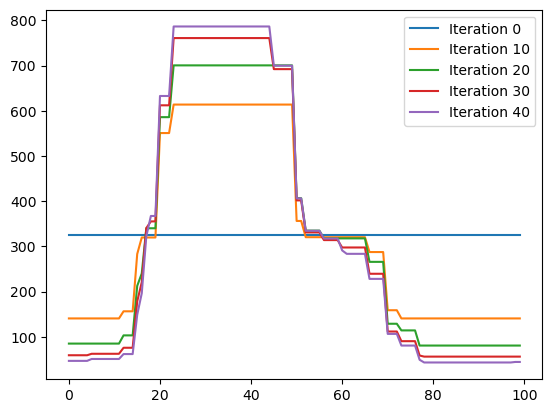

In [138]:
A_final = mwem(B, Q, 50, 1.0, len(adult))

The resulting graph shows the progression from uniform data (iteration 0, blue line) to the final result after 25 iterations. The algorithm iteratively converges to a synthetic dataset that roughly mimics the distribution of ages in the Adult dataset. We can also see how the algorithm progresses from fitting the data to the coarse-grained queries (i.e large ranges) in early iterations, toward fine-tuning the data to fine-grained queries (i.e. small ranges) in later iterations. For example, iteration 10 (orange line) includes a coarse-grained estimate of the population between age 50 and age 70. Iteration 20 (green line) refines this part of the population.

# When does MWEM Work?

The MWEM algorithm is simple and effective for *small domains*. In our example (ages in the Adult dataset), the domain size of 100 is no problem at all. For data with multiple dimensions, the domain representation needs to include *all combinations of attribute values*, so the domain size is exponential in the number of dimensions. For 2-dimensional data, MWEM can often work quite well; for higher-dimensional data, it can be difficult or impossible to represent the $A_i$ dictionary due to its size.